<a href="https://colab.research.google.com/github/CAVASOL/aiffel_node/blob/master/cv_project/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification

**학습 목표**

* VGG16 모델을 구현하여 Image Classification task를 진행하고 다양한 방법을 사용하여 모델의 성능 올려봅시다.
* Image classification을 위한 모델의 코드를 이해하고, 스스로 새로운 모델을 만들어서 분류 성능을 높일 수 있습니다.

In [ ]:
# Lib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [ ]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [ ]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아봅시다.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다.

In [ ]:
# parameter Initialization

batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
# 데이터를 시각화하기 위한 함수

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.  
Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다.

In [ ]:
# Training data generator

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다.  
우리는 개와 고양이를 분류하는 task를 수행하기 때문에 class_mode는 'binary'입니다.

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [ ]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

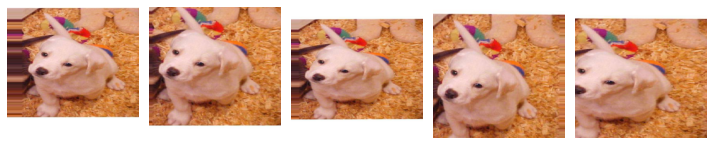

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다.  
그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [ ]:
# Validation data generator

image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 봅시다.

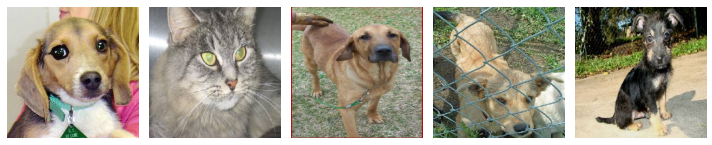

In [ ]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [ ]:
_[:5] # 정답 데이터

array([1., 0., 1., 1., 1.], dtype=float32)

### 문제 1-1. VGG16 모델 구현하기

In [ ]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

손실함수, optimizer, metric을 설정해 줍니다.
손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다.

In [ ]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy

# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.
# callbacks_list = [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

>callbacks_list를 적용하면 전체 에폭 5회 중 첫 번째 에폭에서 학습이 멈췄습니다.  
>설정한 에폭을 모두 학습한 결과를 알아보기 위해 callbacks_list을 주석 처리한 후 다시 학습을 진행했습니다.

In [ ]:
history = model.fit(
          train_data_gen,
          steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
          epochs=epochs,
          validation_data=val_data_gen,
          # callbacks=callbacks_list,
          validation_freq=1)

Epoch 1/5
125/125 [==============================] - 56s 368ms/step - loss: 760.6287 - binary_accuracy: 0.4800 - val_loss: 5.1495 - val_binary_accuracy: 0.5070
Epoch 2/5
125/125 [==============================] - 45s 361ms/step - loss: 0.9942 - binary_accuracy: 0.4940 - val_loss: 2.5098 - val_binary_accuracy: 0.5020
Epoch 3/5
125/125 [==============================] - 44s 353ms/step - loss: 1.0122 - binary_accuracy: 0.4995 - val_loss: 0.8379 - val_binary_accuracy: 0.4930
Epoch 4/5
125/125 [==============================] - 45s 358ms/step - loss: 0.7375 - binary_accuracy: 0.5120 - val_loss: 0.7098 - val_binary_accuracy: 0.4990
Epoch 5/5
125/125 [==============================] - 45s 356ms/step - loss: 0.6956 - binary_accuracy: 0.5175 - val_loss: 0.7033 - val_binary_accuracy: 0.5090


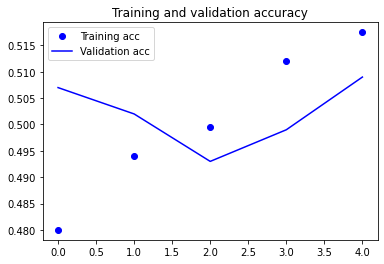

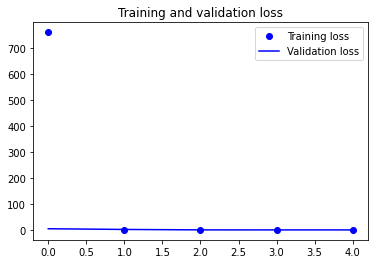

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

성능이 좋지 않음을 확인할 수 있습니다.

### 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기

In [ ]:
# 문제 1-2. hyperparameter 설정

# parameter Initialization
batch_size = 64
epochs = 10
IMG_HEIGHT = 255
IMG_WIDTH = 255

In [ ]:
# 문제 1-2. 데이터 generator 생성

# 위에서 설정했던 Training data generator
# image_gen_train = ImageDataGenerator(rescale=1./255,
#                                      rotation_range=0.3,
#                                      width_shift_range=0.1,
#                                      height_shift_range=0.1,
#                                      zoom_range=0.2,
#                                      horizontal_flip=True,
#                                      vertical_flip=False)

# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range = 0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode = 'nearest')

In [ ]:
# 문제 1-2. 모델 구현

import tensorflow as tf

input_layer = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 37, 37, 64)        0   

In [ ]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
from tensorflow.keras.optimizers import RMSprop

loss_function=tf.keras.losses.binary_crossentropy
# optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy

# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.
# callbacks_list = [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]

model.compile(loss=loss_function,
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=metric)

In [ ]:
# 모델 학습

history = model.fit(
          train_data_gen,
          steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
          epochs=epochs,
          validation_data=val_data_gen,
          # callbacks=callbacks_list,
          validation_freq=1)

Epoch 1/10
31/31 [==============================] - 12s 351ms/step - loss: 0.6980 - binary_accuracy: 0.5273 - val_loss: 0.6962 - val_binary_accuracy: 0.5000
Epoch 2/10
31/31 [==============================] - 11s 349ms/step - loss: 0.6513 - binary_accuracy: 0.6152 - val_loss: 0.7073 - val_binary_accuracy: 0.5000
Epoch 3/10
31/31 [==============================] - 11s 347ms/step - loss: 0.6765 - binary_accuracy: 0.5723 - val_loss: 0.7162 - val_binary_accuracy: 0.5000
Epoch 4/10
31/31 [==============================] - 11s 347ms/step - loss: 0.6632 - binary_accuracy: 0.5801 - val_loss: 0.7339 - val_binary_accuracy: 0.5000
Epoch 5/10
31/31 [==============================] - 11s 342ms/step - loss: 0.6649 - binary_accuracy: 0.5977 - val_loss: 0.7682 - val_binary_accuracy: 0.5000
Epoch 6/10
31/31 [==============================] - 11s 343ms/step - loss: 0.6451 - binary_accuracy: 0.6016 - val_loss: 0.7918 - val_binary_accuracy: 0.5000
Epoch 7/10
31/31 [==============================] - 11s 34

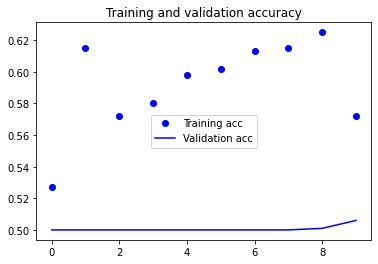

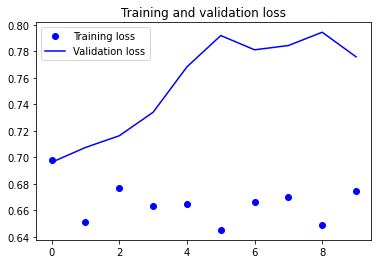

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()